# KNN, рак и спам
__Суммарное количество баллов: 12__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import copy
import pandas
import matplotlib.pyplot as plt
import matplotlib
from typing import NoReturn, Tuple, List

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
from task import read_cancer_dataset, read_spam_dataset

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [3]:
from task import train_test_split

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [4]:
from task import get_precision_recall_accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [5]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [6]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь приступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [7]:
from task import KDTree

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [8]:
tuple(np.array([-1.32085207,  0.])) > (-1, -1)

False

In [9]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(1000, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

In [10]:
a = np.array([[0,0],[0,1],[0,2],[2,0],[0,1],[1,0],[0,0]])
b = np.array([[0,0]])

In [11]:
true_closest(np.array([[0,0],[0,1],[0,2],[2,0],[0,1],[1,0],[0,0]]), np.array([[0,0]]), k=2)

[[0, 6]]

In [12]:
t = KDTree(a, leaf_size=2)
t.query(b, k=8)

In [13]:
print(predicted)

[[571, 254, 348, 555], [709, 896, 809, 707], [393, 166, 629, 500], [537, 376, 455, 728], [315, 542, 878, 868], [511, 264, 226, 125], [276, 881, 901, 666], [641, 638, 993, 837], [479, 943, 891, 602], [59, 657, 250, 888]]


In [14]:
print(true)

[[571, 254, 348, 555], [709, 896, 809, 707], [393, 166, 629, 500], [537, 376, 455, 728], [315, 542, 878, 868], [511, 264, 226, 125], [276, 881, 901, 666], [641, 638, 993, 837], [479, 943, 891, 602], [59, 657, 250, 888]]


In [16]:
np.linalg.norm(X_test[0]-X_train[607])

0.2605233105846388

In [16]:
np.linalg.norm(X_train - X_test[0], axis=1)[358]

0.44482403913783325

In [42]:
root = [(i, X_train[i]) for i in range(len(X_train))]
coord = np.array([i[1] for i in root])
distances = np.linalg.norm(coord - X_test[0], axis=1)
roots = np.array([(-distances[i], -int(root[i][0])) for i in range(len(distances))])
sorted(roots, key=lambda element: (-element[0], -element[1]))

[array([-3.08214659e-01, -7.05000000e+02]),
 array([  -0.44482404, -358.        ]),
 array([-4.81095927e-01, -7.40000000e+02]),
 array([-4.96901282e-01, -6.25000000e+02]),
 array([  -0.57790983, -494.        ]),
 array([-5.91806472e-01, -9.23000000e+02]),
 array([-6.09252487e-01, -9.11000000e+02]),
 array([-6.14552129e-01, -6.63000000e+02]),
 array([  -0.61637944, -119.        ]),
 array([  -0.63488848, -552.        ]),
 array([  -0.6399193, -220.       ]),
 array([ -0.66071759, -60.        ]),
 array([ -0.66079913, -64.        ]),
 array([  -0.66477702, -281.        ]),
 array([  -0.68997057, -415.        ]),
 array([-6.95475375e-01, -9.36000000e+02]),
 array([  -0.70224193, -475.        ]),
 array([  -0.7156041, -381.       ]),
 array([  -0.72324543, -148.        ]),
 array([-7.31858706e-01, -7.93000000e+02]),
 array([-7.32432875e-01, -8.93000000e+02]),
 array([-7.336866e-01, -9.800000e+02]),
 array([  -0.74422315, -566.        ]),
 array([  -0.75396788, -556.        ]),
 array([  -0

In [15]:
if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

Encounted 17 errors


### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [15]:
from task import KNearest

Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

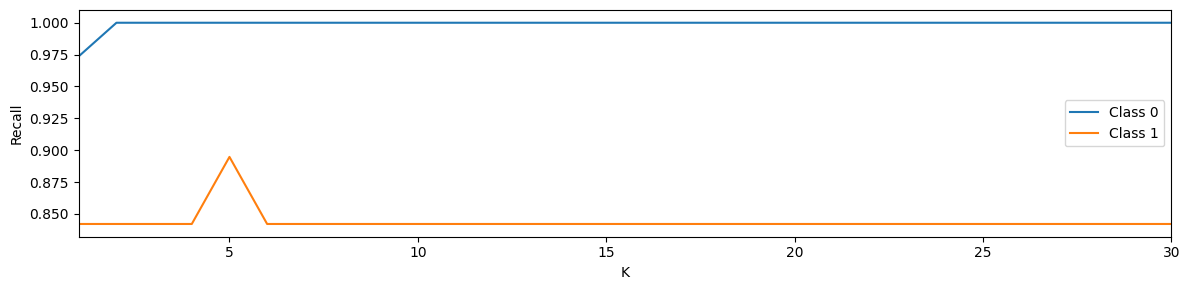

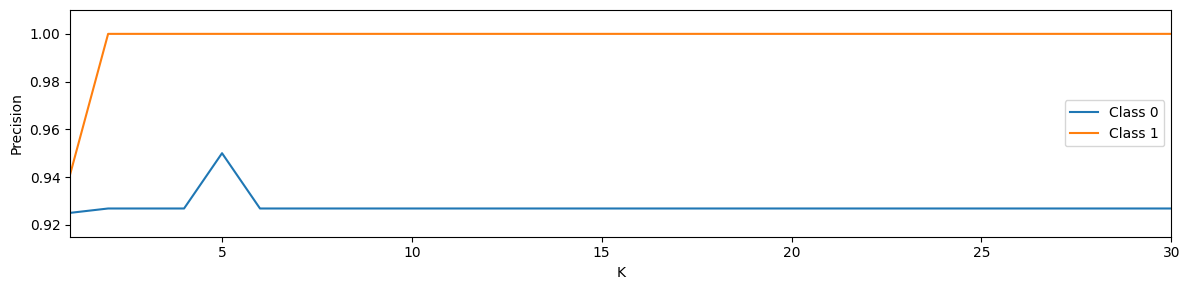

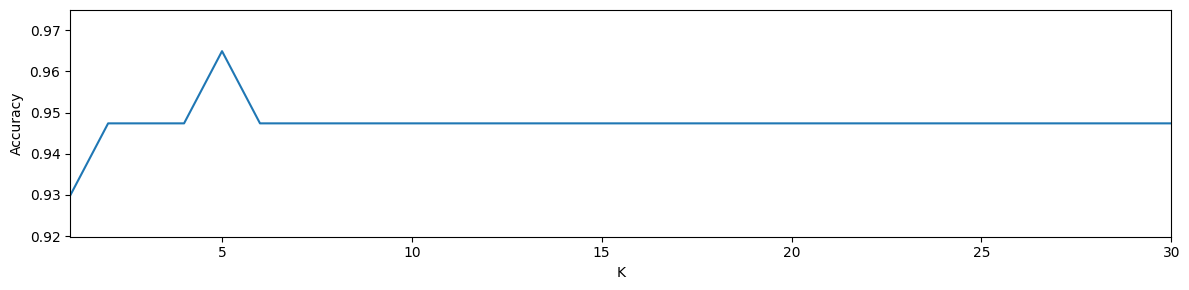

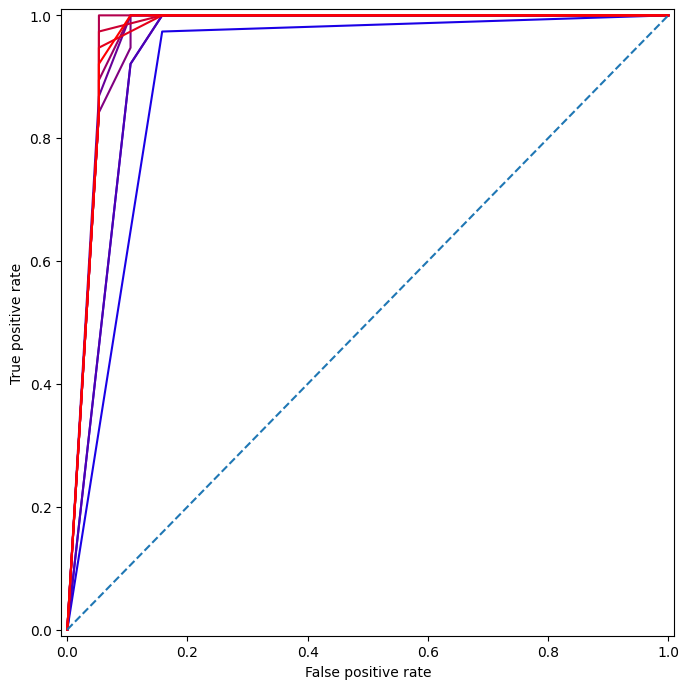

In [16]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

In [21]:
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)
print(true)
print(predicted == true)

[[105, 488, 71, 68], [186, 509, 317, 448], [218, 402, 401, 507], [201, 80, 329, 15], [396, 366, 292, 139], [262, 56, 202, 31], [198, 460, 238, 403], [18, 387, 480, 209], [2, 63, 181, 119], [489, 190, 290, 306], [464, 184, 6, 250], [395, 153, 141, 134], [398, 511, 353, 444], [140, 233, 34, 482], [223, 427, 267, 507], [188, 499, 501, 491], [8, 278, 337, 389], [198, 301, 460, 162], [290, 400, 489, 7], [394, 57, 140, 160], [46, 400, 266, 435], [45, 350, 362, 46], [432, 305, 338, 214], [136, 331, 376, 199], [272, 476, 494, 471], [201, 80, 15, 441], [431, 440, 123, 406], [344, 369, 166, 390], [374, 185, 265, 455], [376, 282, 331, 450], [325, 169, 370, 348], [172, 1, 475, 261], [502, 10, 146, 335], [418, 295, 456, 197], [374, 110, 29, 403], [130, 108, 11, 236], [140, 394, 233, 239], [444, 43, 398, 53], [179, 442, 459, 240], [101, 352, 255, 450], [249, 375, 26, 428], [224, 102, 442, 273], [223, 303, 327, 507], [100, 504, 144, 17], [464, 250, 170, 6], [65, 93, 304, 510], [241, 99, 380, 400], [4

In [40]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)

In [41]:
tree = KDTree(X_train, leaf_size=5)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

In [42]:
a = np.array(predicted)

In [43]:
c = np.array(true)

In [44]:
a

array([[3181,  854,  492, 3949],
       [3544, 2060, 1387, 3060],
       [1723,  587, 3504, 2503],
       ...,
       [1529, 2593, 1261,  884],
       [2516, 2837, 1881,  636],
       [ 102,  896,  973, 3009]])

In [45]:
c

array([[3181,  492,  854, 3949],
       [1387, 2060, 3060, 3544],
       [1723,  587, 3504, 2503],
       ...,
       [1529, 2593, 1261,  884],
       [2516, 2837, 1881,  636],
       [ 102,  896,  973, 3009]])

In [46]:
a == c

array([[ True, False, False,  True],
       [False,  True, False, False],
       [ True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [47]:
np.where(np.any(a != c, axis=1))

(array([  0,   1,   4,  21,  27,  31,  32,  33,  39,  46,  48,  77,  95,
         96, 109, 114, 139, 157, 183, 188, 189, 190, 195, 219, 223, 226,
        243, 258, 261, 263, 271, 275, 284, 291, 293, 301, 305, 310, 311,
        315, 324, 334, 364, 367, 368, 373, 379, 381, 391, 396, 400, 401,
        403, 422, 424, 428, 434, 436, 437, 443, 455], dtype=int64),)

In [26]:
a[63]

array([1713,  614, 1705, 2787])

In [27]:
c[63]

array([1713,  614, 1705, 2787])

In [32]:
math.dist(X_test[63], X_train[1076])

0.0

In [33]:
math.dist(X_test[63], X_train[1027])

0.0

In [27]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4)
neigh.fit(X_train)
b = neigh.kneighbors(X_test, return_distance=False)
b

C:\Users\natag\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\natag\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\natag\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\natag\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1024, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\U

array([[ 279, 2710, 3813,  122],
       [4096, 4094, 3791,  970],
       [ 372, 3273, 3940, 3165],
       ...,
       [1566, 1400, 2419, 2531],
       [2671, 1216, 1729, 1772],
       [  50, 2376, 1532, 1779]], dtype=int64)

In [28]:
a

array([[ 279, 2710, 3813,  122],
       [3791, 4094, 4096,  970],
       [ 372, 3273, 3940, 3165],
       ...,
       [1566, 1400, 2419, 2531],
       [2671, 1216, 1729, 1772],
       [  50, 2376, 1532, 1779]])

In [29]:
np.where(np.any(a != b, axis=1))

(array([  1,   5,  11,  16,  17,  28,  57,  69,  97,  98, 105, 138, 147,
        155, 162, 195, 201, 204, 219, 228, 252, 262, 277, 281, 285, 287,
        288, 290, 293, 322, 330, 352, 355, 362, 379, 384, 389, 399, 400,
        406, 409, 416, 431, 438, 450, 452, 454], dtype=int64),)

In [33]:
a[8:13]

array([[  81, 1604, 2199, 1502],
       [3613, 3695,  289, 2760],
       [2857, 1407,  743, 4116],
       [ 760, 1741, 2131, 1760],
       [  67,  304,  425,  471]])

In [34]:
b[8:13]

array([[2199, 1604,   81, 1502],
       [3613, 3695,  289, 2760],
       [2857, 1407,  743, 4116],
       [ 760, 1741, 2131, 1760],
       [ 471,  425,  304,   67]], dtype=int64)

In [15]:
import math

In [37]:
math.dist(X_test[8], X_train[81])

0.0

In [38]:
math.dist(X_test[8], X_train[2199])

0.0

In [39]:
X_train[81], X_train[2199]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 2., 5., 8.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 2., 5., 8.]))

In [33]:
np.linalg.norm(np.array(X_test[4]) - np.array(X_train[2319]))


23.953898450982877

In [34]:
np.linalg.norm(np.array(X_test[4]) - np.array(X_train[3870]))

23.953898450982877

In [47]:
c[1:7]

array([[1250, 2424, 3529, 4135],
       [ 557,  755, 2158, 3233],
       [1047, 3694, 1087,  386],
       [1562, 3822, 1377, 1398],
       [ 503, 3297, 1995, 2425],
       [ 863, 2991, 3239, 1780]])

In [15]:
X_train = np.random.randn(300000, 2)
X_test = np.random.randn(10, 2)
tree = KDTree(X_train, leaf_size=3)
predicted = tree.query(X_test, k=200)
true = true_closest(X_train, X_test, k=200)

In [16]:
-np.sort(-np.array([(-3, 0),(-3, -4),(-1,-3)]),axis=0)

array([[-1,  0],
       [-3, -3],
       [-3, -4]])

In [17]:
x =[(23, np.array([-0.2634094 , -0.52086209,  0.21859102])), (307, np.array([-0.47980153, -0.44223229,  0.38094768])), (438, np.array([-0.48818011, -0.40392645,  0.83451821]))]

In [18]:
x

[(23, array([-0.2634094 , -0.52086209,  0.21859102])),
 (307, array([-0.47980153, -0.44223229,  0.38094768])),
 (438, array([-0.48818011, -0.40392645,  0.83451821]))]

In [19]:
dx = np.array([i[1] for i in x])
dx

array([[-0.2634094 , -0.52086209,  0.21859102],
       [-0.47980153, -0.44223229,  0.38094768],
       [-0.48818011, -0.40392645,  0.83451821]])

In [20]:
distances = np.linalg.norm(dx - [0,1,1], axis=1)

In [21]:
roott = np.array([(-distances[i], -int(x[i][0])) for i in range(len(distances))])

In [22]:
-np.sort(-roott,axis=0)

array([[  -1.49556462,  -23.        ],
       [  -1.64117923, -307.        ],
       [  -1.73003064, -438.        ]])

In [23]:
X_test

array([[ 0.33103127,  0.29774967],
       [ 0.43244613, -1.0141166 ],
       [ 0.57601989,  1.05553569],
       [-1.10850149,  0.32120823],
       [ 0.81719078,  0.00541537],
       [ 0.87979834,  1.63568756],
       [-1.81247836, -0.6481164 ],
       [-1.17828615, -0.38789983],
       [ 0.45894833, -0.27631402],
       [-1.15622114,  1.98872518]])

In [24]:
a = np.array(true)
b = np.array(predicted)

In [25]:
np.where(np.any(a != b, axis=1))

(array([], dtype=int64),)

In [26]:
a[1]

array([144301, 260563, 247208,  98731,  53122, 262495, 171396, 254477,
       134360, 207372,  73660,  46239, 126905,  19478, 108566, 266503,
       166572, 145666,  79355,  12337, 258641, 138896, 276434,  43783,
        77669, 189231, 284851, 296554, 285606, 212425, 115988, 155707,
        47033,  96782, 146490, 251865,  65166, 226066, 232766,  24620,
       255781,  87589, 143333, 175407, 218887, 132222, 119178, 129937,
       246163, 273071,  22387,  21645, 143731, 224297, 255468, 186480,
       228702,  47513, 212241, 190584, 123737, 135918, 197743, 132120,
       127210, 208901, 202251, 127822,  14167, 264341, 268349, 241279,
       138686, 108757, 297496, 111879, 269342,  27462, 182225, 261937,
         3870, 184567, 141451,   8061,  53760, 124995, 288777,  79134,
       177903, 267793, 277717, 188218, 183255, 298976, 197904, 168870,
         2451, 296862, 266760, 209915, 233706,  38947, 110241,  87193,
       275601, 161659, 299333, 283085,  46515, 139883, 288670, 210879,
      

In [27]:
b[1]

array([144301, 260563, 247208,  98731,  53122, 262495, 171396, 254477,
       134360, 207372,  73660,  46239, 126905,  19478, 108566, 266503,
       166572, 145666,  79355,  12337, 258641, 138896, 276434,  43783,
        77669, 189231, 284851, 296554, 285606, 212425, 115988, 155707,
        47033,  96782, 146490, 251865,  65166, 226066, 232766,  24620,
       255781,  87589, 143333, 175407, 218887, 132222, 119178, 129937,
       246163, 273071,  22387,  21645, 143731, 224297, 255468, 186480,
       228702,  47513, 212241, 190584, 123737, 135918, 197743, 132120,
       127210, 208901, 202251, 127822,  14167, 264341, 268349, 241279,
       138686, 108757, 297496, 111879, 269342,  27462, 182225, 261937,
         3870, 184567, 141451,   8061,  53760, 124995, 288777,  79134,
       177903, 267793, 277717, 188218, 183255, 298976, 197904, 168870,
         2451, 296862, 266760, 209915, 233706,  38947, 110241,  87193,
       275601, 161659, 299333, 283085,  46515, 139883, 288670, 210879,
      

In [14]:
np.linalg.norm(X_test[1]-X_train[99])

3.0669486044081595

In [16]:
np.linalg.norm(X_test[1] - X_train[85])

2.9946629287599293

In [19]:
tree.build_tree([(i, X_train[i]) for i in range(len(X_train))], leaf_size=3)

{'point': (78, array([ 0.00664397, -1.00863571])),
 'left': {'point': (49, array([-1.48812949,  0.08998989])),
  'left': {'point': (103, array([-0.60012837, -1.01022035])),
   'left': {'point': (143, array([-2.05801364, -0.7534058 ])),
    'left': {'point': (76, array([-1.4163545 , -0.99452409])),
     'left': {'point': (251, array([-1.56005398, -0.99093028])),
      'left': [(20, array([-2.36840507, -2.97660724])),
       (257, array([-1.83104272, -1.62786368])),
       (167, array([-2.11055448, -1.48522556])),
       (156, array([-1.68330056, -1.07390037]))],
      'right': [(228, array([-1.67753578, -0.94926871])),
       (285, array([-1.73830628, -0.94917588])),
       (235, array([-1.64960733, -0.94089258])),
       (32, array([-1.45946062, -0.79512067]))]},
     'right': {'point': (269, array([-1.24230383, -0.9872636 ])),
      'left': [(26, array([-1.36130502, -1.8160126 ])),
       (81, array([-0.85027564, -1.35698979])),
       (165, array([-1.2816466 , -1.22744193])),
       

In [53]:
math.dist(X_test[1], X_train[200])

0.7485205103194438

In [33]:
X_train

array([[ 0.03465999, -0.33899895],
       [ 0.33346165,  1.01894052],
       [ 1.45520111,  1.15515933],
       [-1.8449526 , -0.75527718],
       [ 1.2370432 , -1.02876568],
       [-0.86893333, -1.77833607],
       [ 0.36357559,  0.57174984],
       [ 0.77745579, -0.59502325],
       [-0.26089215, -0.84330442],
       [ 0.12582447,  1.6949202 ],
       [-1.15532106,  0.09406051],
       [ 0.85197865, -0.39360925],
       [ 0.45586796,  0.09177822],
       [-0.35470771,  1.25147219],
       [ 0.3176517 , -0.38451266],
       [ 0.56652939, -0.06487448],
       [-1.56039067, -0.48063034],
       [-2.22207427, -1.33158857],
       [-2.01075408,  0.84589414],
       [ 0.92706204, -0.77227841],
       [-0.47674725, -0.35717419],
       [ 1.66945871,  0.48397192],
       [ 1.57654872, -0.24610577],
       [-1.02713236, -0.59659364],
       [-0.53998013,  0.79621387],
       [-1.57247239, -1.01038184],
       [-0.58916826,  0.95727435],
       [-0.74253015, -1.00330292],
       [-0.61232583,

In [ ]:
points.sort(key=lambda x: x[1][axis])

In [31]:
points = [(1, [2,-1]),(0, [0,0])]

In [34]:
np.argsort(points[:][0][1])

array([1, 0], dtype=int64)